      Pharaoh Ancient name             Modern name  Dynasty             Site  \
0      Djoser   Hiemlender  Step Pyramid of Djoser        3          Saqqara   
1  Sekhemkhet            -          Buried Pyramid        3          Saqqara   
2   Khaba (?)            -           Layer Pyramid        3  Zawyet el'Aryan   
3        Huni            -       Pyramid Lepsius I        3       Abu Rawash   
4    Huni (?)            -     Pyramid of Athribis        3         Athribis   

   Base1 (m)  Base2 (m)  Height (m)  Slope (dec degr) Volume (cu.m)  \
0      121.0      109.0        60.0               NaN         330.4   
1      120.0      120.0        70.0               NaN          33.6   
2       84.0       84.0        40.0               NaN         47.04   
3      215.0      215.0       145.0               NaN           NaN   
4       20.0       20.0        16.0              50.0           NaN   

    Latitude  Longitude  Type Lepsius  Material         Comment  
0  29.871215  31.216644  S

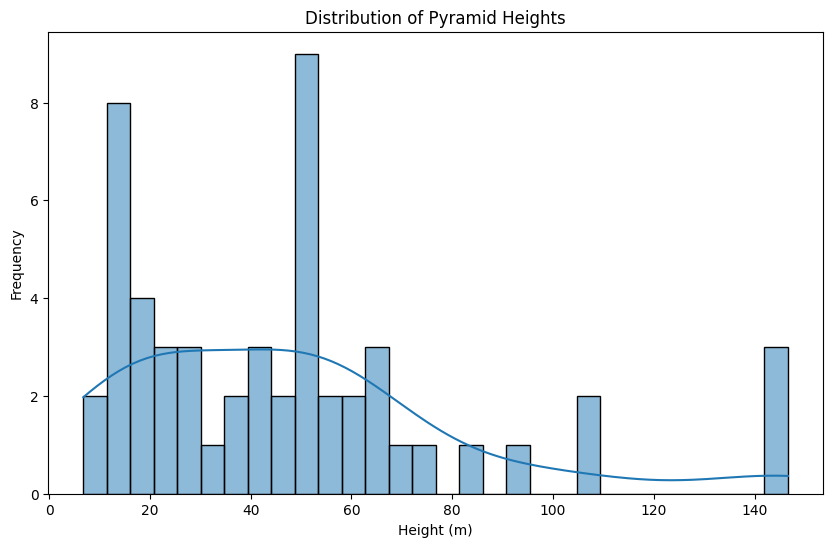

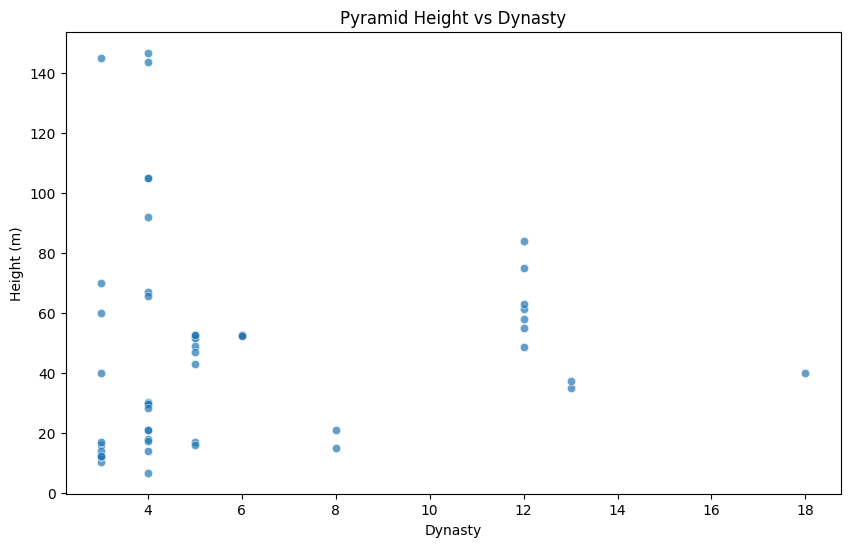

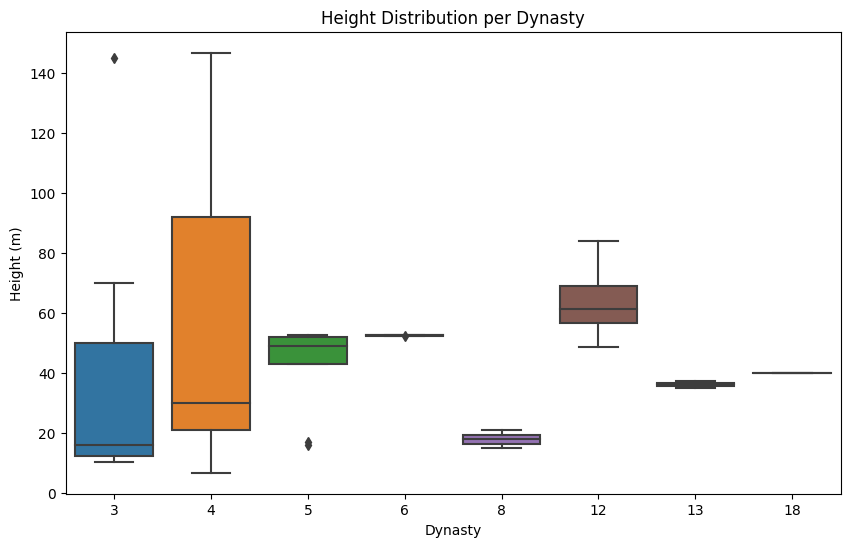

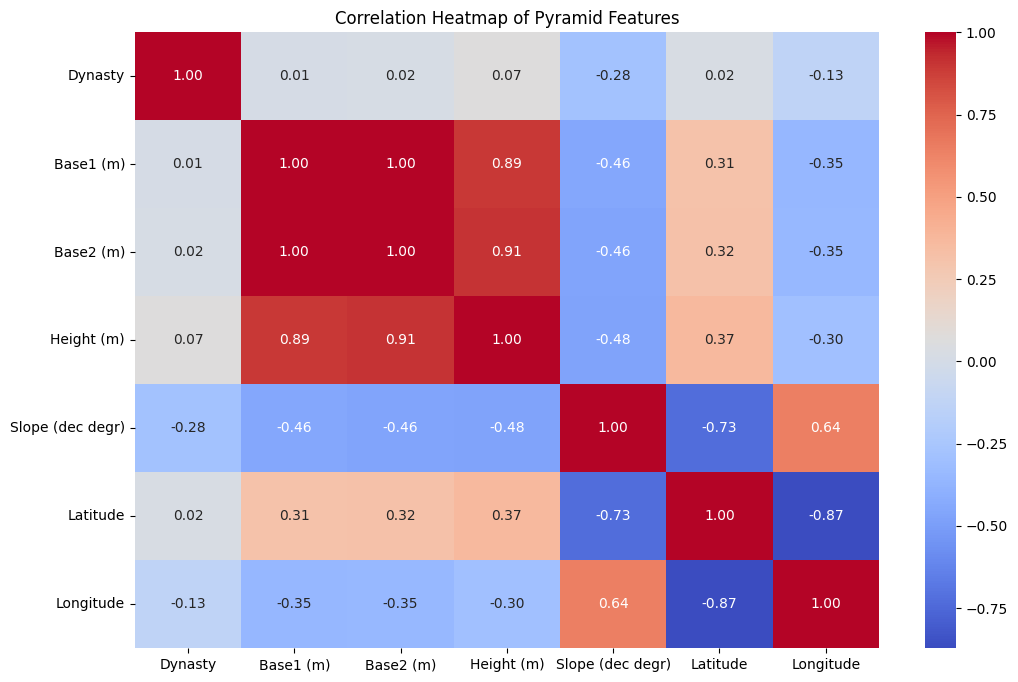

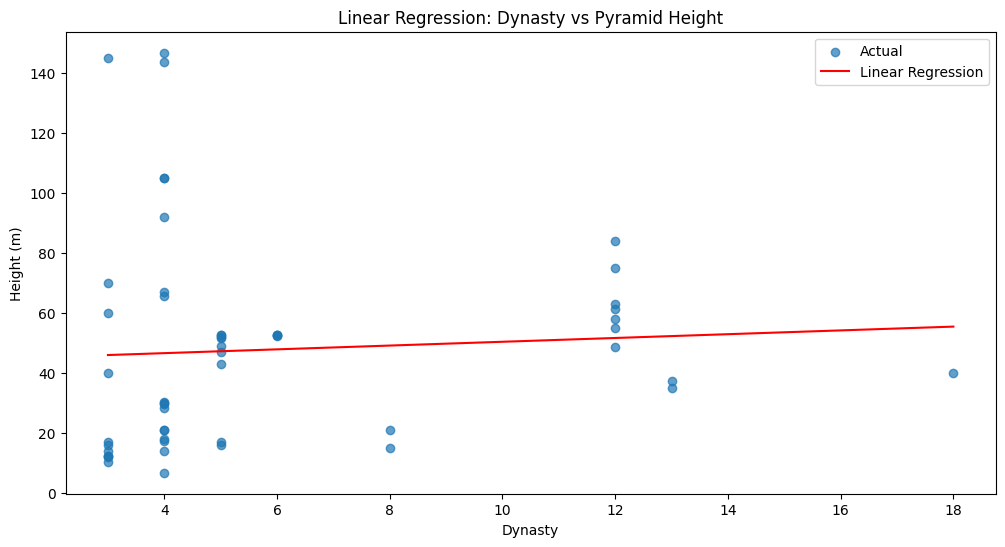

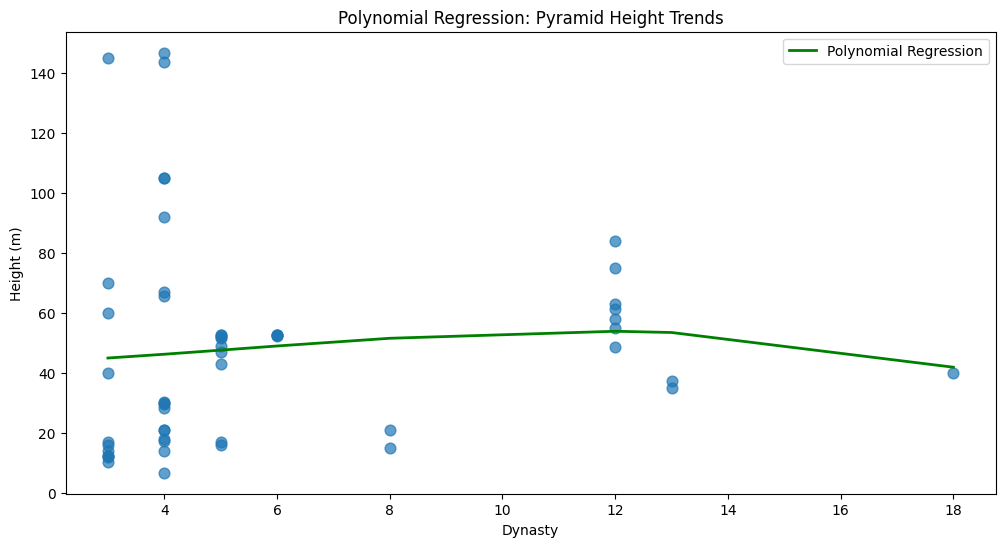

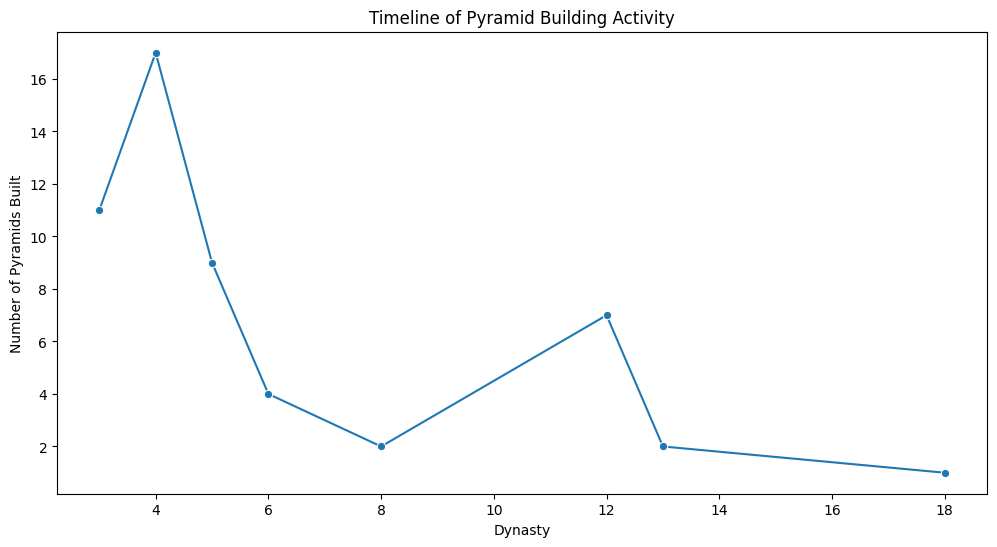

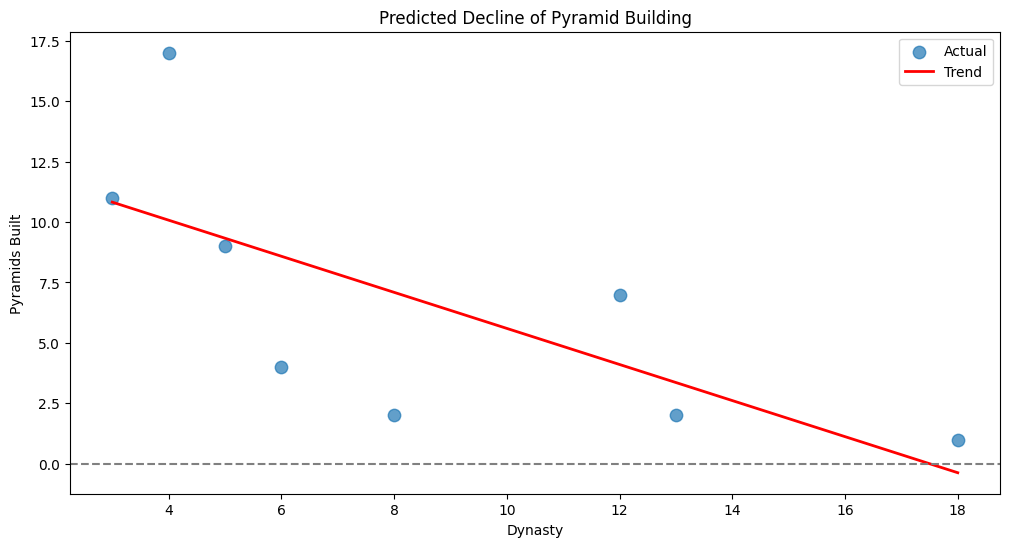

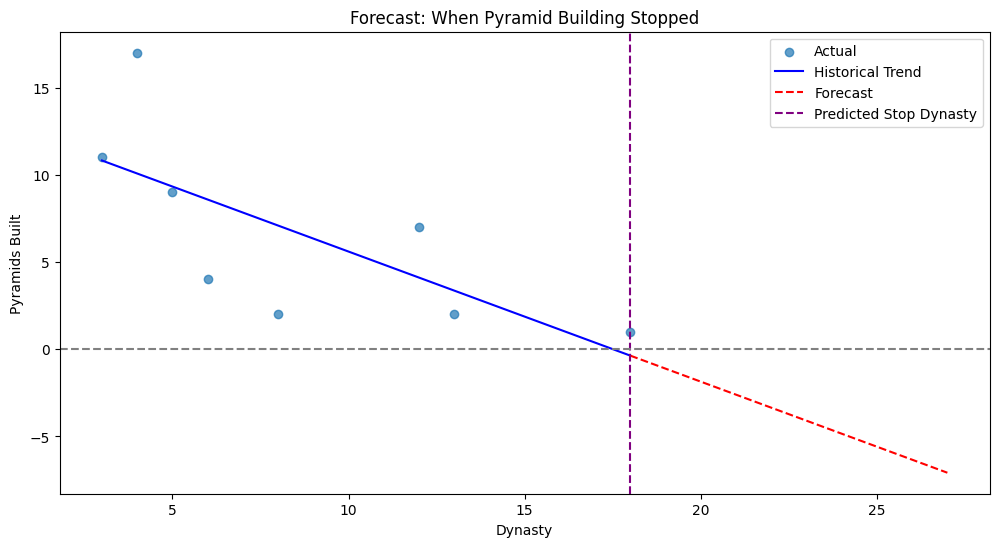


Machine Learning Prediction: Pyramid building activity likely stopped around Dynasty 18
Classification Accuracy (Predicting Dynasty): 0.55

Model Performance:
Linear Regression (Height vs Dynasty)
  MSE: 1142.37
  MAE: 24.97
  R2:  0.00

Cross-validation R2 (Polynomial Regression)
  Mean CV R2: -114.03


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier

#For FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")

#Dataset handling
df = pd.read_csv("/kaggle/input/egyptianpyramids/pyramids.csv")
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=["Height (m)", "Dynasty"])
df = df[df["Height (m)"] > 0]

#Analysis
print(df.head())
df.info()
print(df.describe())
print(df.isnull().sum())
print(f"Duplicated rows: {df.duplicated().sum()}")

#Visualization
plt.figure(figsize=(10, 6))
sns.histplot(df["Height (m)"], bins=30, kde=True)
plt.title("Distribution of Pyramid Heights")
plt.xlabel("Height (m)")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x="Dynasty", y="Height (m)", data=df, alpha=0.7)
plt.title("Pyramid Height vs Dynasty")
plt.xlabel("Dynasty")
plt.ylabel("Height (m)")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x="Dynasty", y="Height (m)", data=df)
plt.title("Height Distribution per Dynasty")
plt.xlabel("Dynasty")
plt.ylabel("Height (m)")
plt.show()

nd = df.select_dtypes(include=np.number)
plt.figure(figsize=(12, 8))
sns.heatmap(nd.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Pyramid Features")
plt.show()

#Regression
X = df[["Dynasty"]]
y = df["Height (m)"]

lin_model = LinearRegression()
lin_model.fit(X, y)
y_pred = lin_model.predict(X)

plt.figure(figsize=(12, 6))
plt.scatter(df["Dynasty"], y, alpha=0.7, label="Actual")
plt.plot(df["Dynasty"], y_pred, color="red", label="Linear Regression")
plt.title("Linear Regression: Dynasty vs Pyramid Height")
plt.xlabel("Dynasty")
plt.ylabel("Height (m)")
plt.legend()
plt.show()

poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)
poly_model = LinearRegression()
poly_model.fit(X_poly, y)
y_poly_pred = poly_model.predict(X_poly)

plt.figure(figsize=(12, 6))
plt.scatter(df["Dynasty"], y, alpha=0.7, s=60)
plt.plot(df["Dynasty"], y_poly_pred, color="green", linewidth=2, label="Polynomial Regression")
plt.title("Polynomial Regression: Pyramid Height Trends")
plt.xlabel("Dynasty")
plt.ylabel("Height (m)")
plt.legend()
plt.show()

#Timeline of Pyramid Activity
activity = df.groupby("Dynasty").size().reset_index(name="Pyramids Built")
plt.figure(figsize=(12, 6))
sns.lineplot(x="Dynasty", y="Pyramids Built", data=activity, marker="o", errorbar=None)
plt.title("Timeline of Pyramid Building Activity")
plt.xlabel("Dynasty")
plt.ylabel("Number of Pyramids Built")
plt.show()

# Predict decline using regression
X_act = activity[["Dynasty"]]
y_act = activity["Pyramids Built"]

act_model = LinearRegression()
act_model.fit(X_act, y_act)
act_preds = act_model.predict(X_act)

plt.figure(figsize=(12, 6))
plt.scatter(activity["Dynasty"], y_act, s=80, alpha=0.7, label="Actual")
plt.plot(activity["Dynasty"], act_preds, color="red", linewidth=2, label="Trend")
plt.axhline(0, color="gray", linestyle="--")
plt.title("Predicted Decline of Pyramid Building")
plt.xlabel("Dynasty")
plt.ylabel("Pyramids Built")
plt.legend()
plt.show()

#When Pyramid Building Stopped
last_dynasty = df["Dynasty"].max()
future_dynasties = pd.DataFrame({"Dynasty": np.arange(last_dynasty, last_dynasty + 10)})

future_preds = act_model.predict(future_dynasties)

plt.figure(figsize=(12, 6))
plt.scatter(activity["Dynasty"], y_act, label="Actual", alpha=0.7)
plt.plot(activity["Dynasty"], act_preds, color="blue", label="Historical Trend")
plt.plot(future_dynasties["Dynasty"], future_preds, color="red", linestyle="--", label="Forecast")
plt.axvline(x= (future_dynasties["Dynasty"][future_preds <= 0].min() or last_dynasty), color="purple", linestyle="--", label="Predicted Stop Dynasty")
plt.axhline(0, color="gray", linestyle="--")

plt.title("Forecast: When Pyramid Building Stopped")
plt.xlabel("Dynasty")
plt.ylabel("Pyramids Built")
plt.legend()
plt.show()

stop_dynasty = future_dynasties["Dynasty"][future_preds <= 0].min()
print(f"\nMachine Learning Prediction: Pyramid building activity likely stopped around Dynasty {stop_dynasty}")

#Dynasty Prediction
possible_features = ["Height (m)", "Base (m)", "Volume (m3)"]
features = [f for f in possible_features if f in df.columns]

if features:
    df_cls = df.dropna(subset=features + ["Dynasty"])
    X_class = df_cls[features]
    y_class = df_cls["Dynasty"]

    X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.2, random_state=42)
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print(f"Classification Accuracy (Predicting Dynasty): {score:.2f}")
else:
    print("\n Skipping classification: no suitable features available in dataset.")

#Report
print("\nModel Performance:")
print("Linear Regression (Height vs Dynasty)")
print(f"  MSE: {mean_squared_error(y, y_pred):.2f}")
print(f"  MAE: {mean_absolute_error(y, y_pred):.2f}")
print(f"  R2:  {r2_score(y, y_pred):.2f}")

print("\nCross-validation R2 (Polynomial Regression)")
cv_scores = cross_val_score(poly_model, X_poly, y, cv=5, scoring='r2')
print(f"  Mean CV R2: {cv_scores.mean():.2f}")
